In [36]:
import numpy as np
from numpy.random import rand,randn,randint,poisson,gamma,multinomial
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def corr(trace):
    """ calculate the autocorrelation of a trace of scalar data
    pre:  trace should be a 1D iterable array of floating point numbers
    post: return the autocorrelation of this trace of scalars
    """

    mu     = np.mean(trace)
    stddev = np.std(trace,ddof=1)

    correlation_time = 0.
    for k in range(1,len(trace)):
        # calculate auto_correlation
        auto_correlation = 0.0
        num = len(trace)-k
        for i in range(num):
            auto_correlation += (trace[i]-mu)*(trace[i+k]-mu)
        # end for i
        auto_correlation *= 1.0/(num*stddev**2)
        if auto_correlation > 0:
            correlation_time += auto_correlation
        else:
            break
        # end if
    # end for k

    correlation_time = 1.0 + 2.0*correlation_time
    return correlation_time

# end def corr

def error(trace):
    """ calculate the standard error of a trace of scalar data
    for uncorrelated data, this should match np.std(trace)/np.sqrt(len(trace))
    pre:  trace should be a 1D iterable array of floating point numbers
    post: return the standard error of this trace of scalars 
    """

    # calculate standard error
    return np.std(trace,ddof=1)/np.sqrt(len(trace)/corr(trace))

# end def error

In [38]:
# seed RNG for reproducibility
seed = 9
np.random.seed(seed)

# generate data
N=50
a=2
b=1
true_n = randint(N)
true_lam1 = gamma(a,1./b)
true_lam2 = gamma(a,1./b)
x = np.concatenate( [poisson(true_lam1,true_n)
                   , poisson(true_lam2,N-true_n)] )
print true_n, true_lam1,true_lam2

28 5.11350788519 1.22436931535


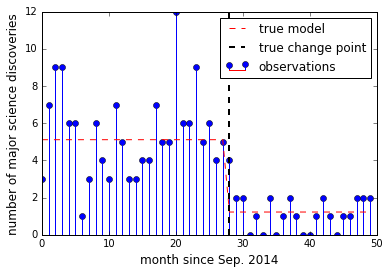

In [39]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel('month since Sep. 2014',fontsize=12)
ax.set_ylabel('number of major science discoveries',fontsize=12)

ax.stem(x,label='observations')

lam = np.zeros(len(x))
lam[:true_n] = true_lam1
lam[true_n:] = true_lam2
ax.plot(lam,c='r',ls='--',label='true model')

ax.axvline(28,lw=2,c='black',ls='--',label='true change point')
ax.legend()
#fig.savefig('change_point_model.png',dpi=200)

In [40]:
nequil = 0
nsample= 1000

# initialize model
n=randint(N)
lam1 = gamma(a,1./b)
lam2 = gamma(a,1./b)
ln_xfac = np.log( factorial(x) )

# make space for traces
trace_n = np.zeros(nsample,dtype=int)
trace_lam1 = np.zeros(nsample)
trace_lam2 = np.zeros(nsample)

# run MCMC 
for istep in range(nequil+nsample):
    
    # block sample new lambda1 and lambda2
    alam1 = a + sum(x[:n])
    blam1 = b + n
    alam2 = a + sum(x[n:])
    blam2 = b + (N-n)
    lam1 = gamma(alam1,1./blam1)
    lam2 = gamma(alam2,1./blam2)
    
    # sample new n
    mult_n = np.zeros(N)
    for i in range(N):
        #mult_n[i] = sum(x[:i])*np.log(lam1) - i*lam1 - i*sum(ln_xfac[:i]) +\
        #            sum(x[i:])*np.log(lam2) + i*lam2 + i*sum(ln_xfac[i:])
        mult_n[i] = sum(x[:i])*np.log(lam1) - i*lam1 + sum(x[i:])*np.log(lam2)+i*lam2# - i*sum(ln_xfac[:i])+i*sum(ln_xfac[i:]) 
    # end for i
    mult_n = np.exp(mult_n-max(mult_n))
    n = np.where( multinomial(1,mult_n/sum(mult_n))==1 )[0][0]
    
    if istep >= nequil:
        trace_n[istep-nequil]    = n
        trace_lam1[istep-nequil] = lam1
        trace_lam2[istep-nequil] = lam2
    # end if istep
    
# end for istep

In [41]:
mylam1 = np.mean(trace_lam1)
mylam1e= error(trace_lam1)
mylam2 = np.mean(trace_lam2)
mylam2e= error(trace_lam2)
myn    = int(round( np.mean(trace_n) ))
myne   = error(trace_n)
print 'estimate:', myn, mylam1, mylam2
print 'errors:', myne, mylam1e, mylam2e
print 'true:    ', true_n,true_lam1,true_lam2

estimate: 29 5.23579572573 1.13405155194
errors: 0.0266129716486 0.0136634899154 0.00841787516529
true:     28 5.11350788519 1.22436931535


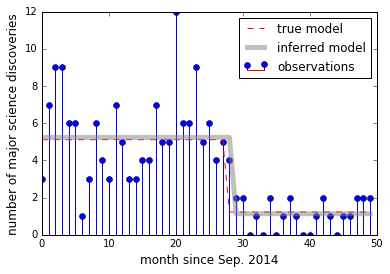

In [42]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel('month since Sep. 2014',fontsize=12)
ax.set_ylabel('number of major science discoveries',fontsize=12)

ax.stem(x,label='observations')

lam = np.zeros(len(x))
lam[:true_n] = true_lam1
lam[true_n:] = true_lam2

mylam = np.zeros(len(x))
mylam[:myn] = mylam1
mylam[myn:] = mylam2

ax.plot(lam,c='r',ls='--',label='true model')
ax.plot(mylam,c='gray',ls='-',lw=5,alpha=0.5,label='inferred model')

ax.legend()
#fig.savefig('change_point_gibbs.png',dpi=200)

In [44]:
gtrace_lam1 = trace_lam1.copy()

### Metropolis

In [45]:
def ln_ppoisson(x,lam):
    return x*np.log(lam)-lam
# end def
def ln_pgamma(lam,a,b):
    return (a-1)*np.log(lam)-b*lam
# end def
def ln_prob(n,lam1,lam2):
    first  = sum( ln_ppoisson(x[:n],lam1) )
    second = sum( ln_ppoisson(x[n:],lam2) )
    plam1  = ln_pgamma(lam1,a,b)
    plam2  = ln_pgamma(lam2,a,b)
    return sum([first,second,plam1,plam2])
# end def

In [46]:
np.random.seed(5)
nequil = 0
nsample= 1000
nsubstep=80
sig = 0.05

# initialize model
n=randint(N)
lam1 = gamma(a,1./b)
lam2 = gamma(a,1./b)
old_ln_prob = ln_prob(n,lam1,lam2)

# make space for traces
trace_n = np.zeros(nsample,dtype=int)
trace_lam1 = np.zeros(nsample)
trace_lam2 = np.zeros(nsample)
naccept = 0

# run MCMC
for istep in range(nequil+nsample):
    
    for isub in range(nsubstep):
        # propose new lambda1, lambda2, and n
        new_lam1 = lam1 + sig*randn()
        new_lam2 = lam2 + sig*randn()
        new_n    = randint(N)

        new_ln_prob = ln_prob(new_n,new_lam1,new_lam2)

        accept = np.exp(new_ln_prob-old_ln_prob)
        if rand()<accept:
            lam1 = new_lam1
            lam2 = new_lam2
            n    = new_n
            naccept += 1
            old_ln_prob = new_ln_prob
        # end if
    # end for isub
    
    if istep >= nequil:
        trace_n[istep-nequil]    = n
        trace_lam1[istep-nequil] = lam1
        trace_lam2[istep-nequil] = lam2
    # end if istep
    
# end for istep

In [47]:
float(naccept)/(nsample*nsubstep)

0.0441375

In [50]:
ndiscard = 400
mylam1 = np.mean(trace_lam1[ndiscard:])
mylam1e= error(trace_lam1[ndiscard:])
mylam2 = np.mean(trace_lam2[ndiscard:])
mylam2e= error(trace_lam2[ndiscard:])
myn    = int(round( np.mean(trace_n[ndiscard:]) ))
myne   = error(trace_n[ndiscard:])
print 'estimate:', myn, mylam1, mylam2
print 'errors:', myne, mylam1e, mylam2e
print 'true:    ', true_n,true_lam1,true_lam2

estimate: 29 5.34029658965 1.15299355761
errors: 0.0720992941166 0.203674296744 0.0435948654433
true:     28 5.11350788519 1.22436931535


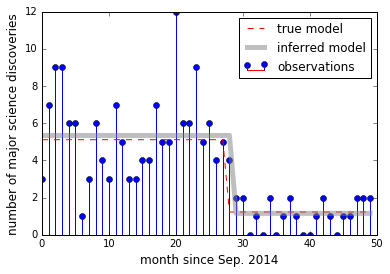

In [52]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel('month since Sep. 2014',fontsize=12)
ax.set_ylabel('number of major science discoveries',fontsize=12)

ax.stem(x,label='observations')

lam = np.zeros(len(x))
lam[:true_n] = true_lam1
lam[true_n:] = true_lam2

mylam = np.zeros(len(x))
mylam[:myn] = mylam1
mylam[myn:] = mylam2

ax.plot(lam,c='r',ls='--',label='true model')
ax.plot(mylam,c='gray',ls='-',lw=5,alpha=0.5,label='inferred model')

ax.legend()
fig.savefig('change_point_mh.png',dpi=200)

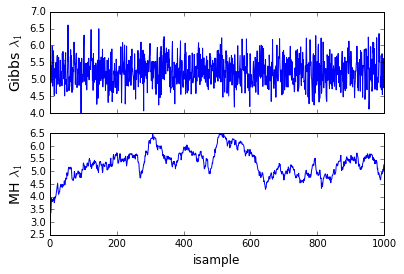

In [58]:
fig,ax = plt.subplots(2,1,sharex=True)

ax[1].set_xlabel('isample',fontsize=12)
ax[0].set_ylabel('Gibbs $\lambda_1$',fontsize=14)
ax[1].set_ylabel('MH $\lambda_1$',fontsize=14)

ax[0].plot(gtrace_lam1)
ax[1].plot(trace_lam1)
#plt.savefig('change_point_traces.png',dpi=200)